# **Paraphrase classification**

In [1]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=a52a198defaa9733f75a503487209311db39f50d3f8629c8bba3d3a33bd0a455
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', None) # show all text in columns

In [3]:
train_df = pd.read_csv('/kaggle/input/paraphrase/train.csv')
# train_df = pd.read_csv('data/train.csv')
train_df

,label,id_1,id_2,text_1,text_2
0,1,702876,702977,"Amrozi accused his brother, whom he called ""the witness"", of deliberately distorting his evidence.","Referring to him as only ""the witness"", Amrozi accused his brother of deliberately distorting his evidence."
1,0,2108705,2108831,Yucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.,Yucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.
2,1,1330381,1330521,"They had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.","On June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale."
3,0,3344667,3344648,"Around 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.","Tab shares jumped 20 cents, or 4.6%, to set a record closing high at A$4.57."
4,1,1236820,1236712,"The stock rose $2.11, or about 11 percent, to close Friday at $21.51 on the New York Stock Exchange.",PG&E Corp. shares jumped $1.63 or 8 percent to $21.03 on the New York Stock Exchange on Friday.
...,...,...,...,...,...
3571,1,1466168,1466246,"During the flight, engineers misjudged the extent of the damage, and even during that period they lamented that the liftoff photography was poor.","During the flight, engineers underestimated the extent of the damage, and even then lamented that the liftoff photography was so poor."
3572,0,2245085,2245118,"The Web site is registered to Parson under his home address, allowing investigators to trace him easily.","The t33kid.com site is registered to Parson at an address in Hopkins, Minnesota."
3573,1,3237867,3237902,"The woman, Mary Kathryn Miller, 55, was arrested by the state police on Nov. 20 and charged with first-degree larceny.","Mary Kathryn Miller, 55, of 27 Devon Road, Darien, was arrested Nov. 20 by state police and charged with first-degree larceny."
3574,0,2194711,2194792,"The Hubble Space Telescope's newest picture of Mars shows summer on the Red Planet just as it makes its closest pass by Earth in 60,000 years.","The pictures were taken late Tuesday and early Wednesday as the as the planet made its closest pass by Earth in 60,000 years."


In [4]:
train_df['label'].value_counts()

label
1    2407
0    1169
Name: count, dtype: int64

In [5]:
from sentence_transformers.cross_encoder import CrossEncoder

model_name = 'cross-encoder/stsb-roberta-large'
model = CrossEncoder(model_name, num_labels=1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# preprocessing: tokenize and remove punctuations
from string import punctuation  
from nltk.tokenize import word_tokenize

def preprocess(sent):
    # lowercase
#     sent = sent.lower()

    # use the model's default tokenizer to tokenize the sentence
    tokens = word_tokenize(sent)

    # remove punctuations
    tokens = [token for token in tokens if token not in punctuation]

    return " ".join(tokens)

In [7]:
sent_1 = np.array(train_df['text_1'].apply(preprocess))
sent_2 = np.array(train_df['text_2'].apply(preprocess))
labels = np.array(train_df['label'])

In [8]:
from sentence_transformers import InputExample
from torch.utils.data import DataLoader

train_examples = []
for i in range(len(sent_1)):
    train_examples.append(InputExample(texts=[sent_1[i], sent_2[i]], label=float(labels[i])))

train_dataset = DataLoader(train_examples, shuffle=True, batch_size=16)

In [9]:
train_dataset

In [10]:
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator

dev_df = pd.read_csv('/kaggle/input/paraphrase/dev.csv')

dev_sent_1 = np.array(dev_df['text_1'].apply(preprocess))
dev_sent_2 = np.array(dev_df['text_2'].apply(preprocess))
dev_labels = np.array(dev_df['label'])

dev_examples = []
for i in range(len(dev_sent_1)):
    dev_examples.append(InputExample(texts=[dev_sent_1[i], dev_sent_2[i]], label=float(dev_labels[i])))

evaluator = CECorrelationEvaluator.from_input_examples(dev_examples, name='dev')

In [11]:
warmup_steps = int(len(train_examples) * 0.1)  # 10% of train data

In [12]:
import torch
torch.cuda.empty_cache()

In [13]:
model.fit(train_dataloader=train_dataset,
          evaluator=evaluator,
          epochs=5,
          evaluation_steps=1500,
          warmup_steps=warmup_steps)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/224 [00:00<?, ?it/s]

Iteration:   0%|          | 0/224 [00:00<?, ?it/s]

Iteration:   0%|          | 0/224 [00:00<?, ?it/s]

Iteration:   0%|          | 0/224 [00:00<?, ?it/s]

Iteration:   0%|          | 0/224 [00:00<?, ?it/s]

In [14]:
name = model_name.split('/')[1] if len(model_name.split('/')) > 1 else model_name.split('/')[0]
model.save('/kaggle/working/model')

In [15]:
test_df = pd.read_csv('/kaggle/input/paraphrase/test.csv')

test_sent_1 = np.array(test_df['text_1'].apply(preprocess))
test_sent_2 = np.array(test_df['text_2'].apply(preprocess))
test_labels = np.array(test_df['label'])

test_pairs = []
for i in range(len(test_sent_1)):
    test_pairs.append([test_sent_1[i], test_sent_2[i]])

In [16]:
saved_model = CrossEncoder('/kaggle/working/model', num_labels=1)

In [17]:
test_similarity_scores = saved_model.predict(test_pairs)

test_df['similarity'] = test_similarity_scores
test_df.groupby('label')['similarity'].describe()

Batches:   0%|          | 0/54 [00:00<?, ?it/s]

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,578.0,0.151889,0.348321,0.001768,0.001820,0.001906,0.002628,0.999689
1,1147.0,0.917133,0.265475,0.001790,0.999406,0.999672,0.999692,0.999699


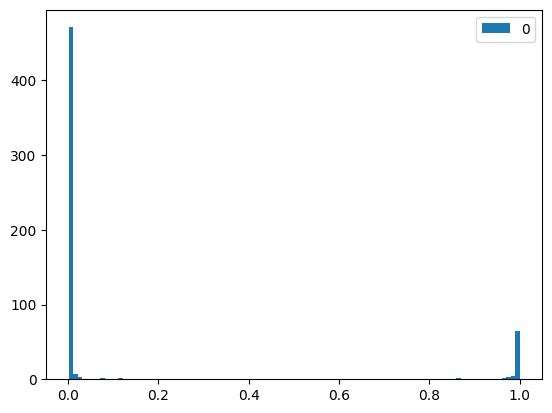

In [18]:
import matplotlib.pyplot as plt

plt.hist(test_df[test_df['label'] == 0]['similarity'], bins=100, label='0')
plt.legend(loc='upper right')
plt.show()

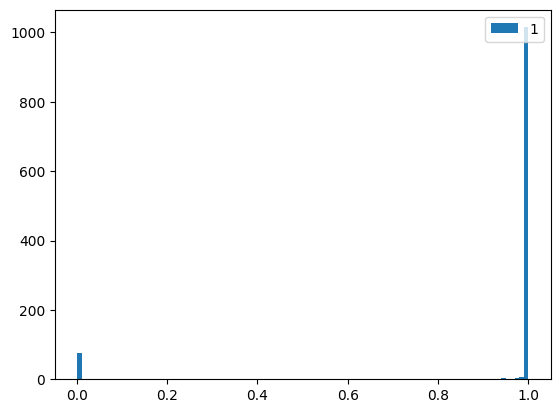

In [19]:
plt.hist(test_df[test_df['label'] == 1]['similarity'], bins=100, label='1')
plt.legend(loc='upper right')
plt.show()

In [20]:
from sklearn.metrics import classification_report

test_df['prediction'] = test_df['similarity'].apply(lambda x: 1 if x >= 0.5 else 0)
print(classification_report(test_df['label'], test_df['prediction'], digits=4))

              precision    recall  f1-score   support

           0     0.8405    0.8478    0.8441       578
           1     0.9229    0.9189    0.9209      1147

    accuracy                         0.8951      1725
   macro avg     0.8817    0.8833    0.8825      1725
weighted avg     0.8953    0.8951    0.8952      1725



In [21]:
wrong_preds = test_df[test_df['label'] != test_df['prediction']]
print(len(wrong_preds), len(test_df))
wrong_preds.to_csv(f'/kaggle/working/wrong_preds_{name}.csv', index=False)

181 1725


In [22]:
test_df.to_csv(f'/kaggle/working/prediction_{name}.csv', index=False)